In [1]:
import polars as pl
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.multitest import multipletests

In [2]:
# -----------------------------
# Load parquet files
# -----------------------------

raf = pl.read_parquet("../evaluation/raf/movie_emotion_summary.parquet")
best = pl.read_parquet("../evaluation/pixa_v2/movie_emotion_summary.parquet")

raf = raf.with_columns(pl.lit("raf").alias("model"))
best = best.with_columns(pl.lit("best").alias("model"))
best = best[raf.columns]

df = pl.concat([raf, best])


FileNotFoundError: No such file or directory (os error 2): ../evaluation/raf/movie_emotion_summary.parquet

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'sink'


In [ ]:
best.columns

In [ ]:
# -----------------------------
# Keep only needed columns
# -----------------------------

emotion_cols = [
    "angry_pct", "fear_pct", "happy_pct",
    "sad_pct", "surprise_pct"
]

df = df.select(
    ["movie", "model"] + emotion_cols
)


In [3]:
# -----------------------------
# Load your genre JSON
# -----------------------------

genre_map = pd.read_json("movie_list.json")

# merge
df = df.to_pandas()
df = df.merge(
    genre_map,
    left_on="movie",
    right_on="file_name",
    how="left"
)

df = df.drop(columns=["file_name"])


NameError: name 'df' is not defined

In [5]:
df.head()

,movie,model,angry_pct,fear_pct,happy_pct,sad_pct,surprise_pct,title,category
0,real_steel,raf,7.658960,5.346821,20.664740,26.734104,39.595376,Real Steel,Sci-Fi
1,point_break,raf,11.339093,1.511879,24.298056,30.021598,32.829374,Point Break,Action
2,jurassic_world,raf,10.000000,3.253012,14.939759,26.385542,45.421687,Jurassic World,Sci-Fi
3,iron_man_3,raf,11.712707,8.618785,16.243094,32.707182,30.718232,Iron Man 3,Action
4,lotr_3,raf,7.680723,2.560241,12.123494,50.602410,27.033133,The Lord of the Rings: The Return of the King,Fantasy


In [6]:
genre_map

,file_name,title,category
0,2_guns,2 Guns,Action
1,300,300,Action
2,47_ronin,47 Ronin,Action
3,9,9,Animation
4,airplane,Airplane!,Comedy
5,amazing_spider-man_the,The Amazing Spider-Man,Action
6,avengers_age_of_ultron,Avengers: Age of Ultron,Action
7,big_hero_6,Big Hero 6,Animation
8,black_mass,Black Mass,Crime
9,blackkklansman,BlacKkKlansman,Crime


In [7]:
def paired_test(df, genre, emotion):

    sub = df[df["category"] == genre]
    
    raf = (
        sub[sub.model == "raf"]
        .sort_values("movie")[emotion]
        .values
    )
    
    best = (
        sub[sub.model == "best"]
        .sort_values("movie")[emotion]
        .values
    )
    
    diff = best - raf
    
    t_stat, p_t = ttest_rel(best, raf)
    w_stat, p_w = wilcoxon(best, raf)
    
    # Cohen's d (paired)
    d = diff.mean() / diff.std(ddof=1)
    
    # Bootstrap CI
    boots = []
    for _ in range(5000):
        sample = np.random.choice(diff, size=len(diff), replace=True)
        boots.append(sample.mean())
    ci_low, ci_high = np.percentile(boots, [2.5, 97.5])
    
    return {
        "genre": genre,
        "emotion": emotion,
        "n": len(diff),
        "mean_diff": diff.mean(),
        "cohens_d": d,
        "t_p": p_t,
        "wilcoxon_p": p_w,
        "ci_low": ci_low,
        "ci_high": ci_high
    }


In [8]:
df.head()

,movie,model,angry_pct,fear_pct,happy_pct,sad_pct,surprise_pct,title,category
0,real_steel,raf,7.658960,5.346821,20.664740,26.734104,39.595376,Real Steel,Sci-Fi
1,point_break,raf,11.339093,1.511879,24.298056,30.021598,32.829374,Point Break,Action
2,jurassic_world,raf,10.000000,3.253012,14.939759,26.385542,45.421687,Jurassic World,Sci-Fi
3,iron_man_3,raf,11.712707,8.618785,16.243094,32.707182,30.718232,Iron Man 3,Action
4,lotr_3,raf,7.680723,2.560241,12.123494,50.602410,27.033133,The Lord of the Rings: The Return of the King,Fantasy


In [9]:
results = []

for genre in df.category.unique():
    for emotion in emotion_cols:
        results.append(
            paired_test(df, genre, emotion)
        )

results_df = pd.DataFrame(results)

# FDR correction (recommended)
results_df["p_adj"] = multipletests(
    results_df["wilcoxon_p"],
    method="fdr_bh"
)[1]

results_df.sort_values("p_adj")


/home/dxd/anaconda3/envs/faces/lib/python3.14/site-packages/scipy/stats/_stats_py.py:1251: RuntimeWarning: divide by zero encountered in divide
  var *= (n / (n-ddof))  # to avoid error on division by zero
/home/dxd/anaconda3/envs/faces/lib/python3.14/site-packages/scipy/stats/_stats_py.py:1251: RuntimeWarning: invalid value encountered in scalar multiply
  var *= (n / (n-ddof))  # to avoid error on division by zero
/home/dxd/anaconda3/envs/faces/lib/python3.14/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dxd/anaconda3/envs/faces/lib/python3.14/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,genre,emotion,n,mean_diff,cohens_d,t_p,wilcoxon_p,ci_low,ci_high,p_adj
6,Action,fear_pct,17,32.755771,3.393076,2.163052e-10,0.000015,28.363421,37.164169,0.000267
9,Action,surprise_pct,17,-31.868467,-5.081300,4.670631e-13,0.000015,-34.702385,-28.934645,0.000267
11,Fantasy,fear_pct,11,36.258174,2.934964,2.033662e-06,0.000977,29.600617,43.425030,0.008545
14,Fantasy,surprise_pct,11,-30.472972,-4.439306,4.180184e-08,0.000977,-34.381663,-26.730167,0.008545
12,Fantasy,happy_pct,11,-5.739749,-1.677776,2.391971e-04,0.001953,-7.638878,-3.807744,0.009766
16,Comedy,fear_pct,10,19.333362,1.746565,3.689935e-04,0.001953,14.190246,26.694302,0.009766
19,Comedy,surprise_pct,10,-33.115162,-5.342637,3.998563e-08,0.001953,-36.785262,-29.546757,0.009766
10,Fantasy,angry_pct,11,6.318281,1.114437,4.134529e-03,0.002930,3.214795,9.437856,0.012817
26,Crime,fear_pct,7,33.188581,2.605902,4.597739e-04,0.015625,23.994003,41.517455,0.042067
18,Comedy,sad_pct,10,7.975045,0.751127,4.154850e-02,0.013672,2.165150,14.444766,0.042067


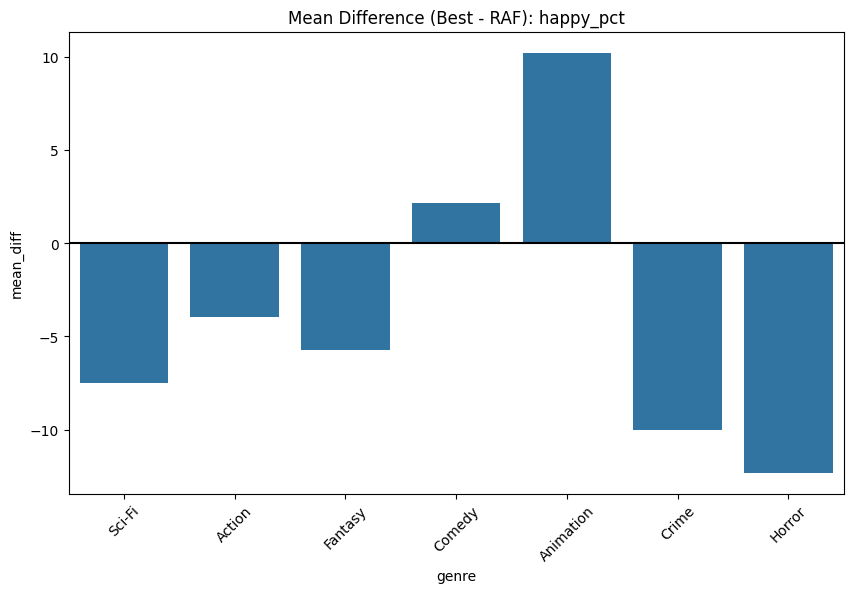

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

emotion = "happy_pct"

plot_df = results_df[results_df.emotion == emotion]

plt.figure(figsize=(10,6))
sns.barplot(
    data=plot_df,
    x="genre",
    y="mean_diff"
)

plt.axhline(0, color="black")
plt.title(f"Mean Difference (Best - RAF): {emotion}")
plt.xticks(rotation=45)
plt.show()


In [11]:
print(results_df.to_markdown())

|    | genre     | emotion      |   n |   mean_diff |     cohens_d |           t_p |   wilcoxon_p |     ci_low |    ci_high |       p_adj |
|---:|:----------|:-------------|----:|------------:|-------------:|--------------:|-------------:|-----------:|-----------:|------------:|
|  0 | Sci-Fi    | angry_pct    |   7 |   6.46542   |   0.591529   |   0.16861     |  0.21875     |  -0.591787 |  14.3135   | 0.31901     |
|  1 | Sci-Fi    | fear_pct     |   7 |  33.3732    |   3.99364    |   4.22745e-05 |  0.015625    |  27.5186   |  38.8285   | 0.0420673   |
|  2 | Sci-Fi    | happy_pct    |   7 |  -7.47327   |  -1.50428    |   0.00728357  |  0.03125     | -10.6626   |  -3.8518   | 0.0643382   |
|  3 | Sci-Fi    | sad_pct      |   7 |   3.75676   |   0.400476   |   0.330124    |  0.296875    |  -2.32756  |  10.8259   | 0.399639    |
|  4 | Sci-Fi    | surprise_pct |   7 | -36.1222    |  -6.77785    |   1.93365e-06 |  0.015625    | -39.5838   | -32.3313   | 0.0420673   |
|  5 | Action    | a

In [12]:
results_df

,genre,emotion,n,mean_diff,cohens_d,t_p,wilcoxon_p,ci_low,ci_high,p_adj
0,Sci-Fi,angry_pct,7,6.465416,0.591529,1.686103e-01,0.218750,-0.591787,14.313458,0.319010
1,Sci-Fi,fear_pct,7,33.373243,3.993641,4.227451e-05,0.015625,27.518552,38.828522,0.042067
2,Sci-Fi,happy_pct,7,-7.473270,-1.504284,7.283568e-03,0.031250,-10.662622,-3.851801,0.064338
3,Sci-Fi,sad_pct,7,3.756765,0.400476,3.301240e-01,0.296875,-2.327564,10.825918,0.399639
4,Sci-Fi,surprise_pct,7,-36.122153,-6.777853,1.933647e-06,0.015625,-39.583771,-32.331344,0.042067
5,Action,angry_pct,17,4.342754,0.476337,6.714885e-02,0.071411,0.450194,8.717920,0.131547
6,Action,fear_pct,17,32.755771,3.393076,2.163052e-10,0.000015,28.363421,37.164169,0.000267
7,Action,happy_pct,17,-3.957013,-0.391046,1.264392e-01,0.063828,-8.282227,0.973088,0.124109
8,Action,sad_pct,17,-1.273045,-0.131204,5.959810e-01,0.853638,-6.019454,3.052546,1.000000
9,Action,surprise_pct,17,-31.868467,-5.081300,4.670631e-13,0.000015,-34.702385,-28.934645,0.000267


In [13]:
results_df.to_csv('ttest_results.csv')

In [14]:
results_df['genre'].unique()

array(['Sci-Fi', 'Action', 'Fantasy', 'Comedy', 'Animation', 'Crime',
       'Horror'], dtype=object)

In [15]:
comedies = genre_map[genre_map['category']=="Comedy"]

In [21]:
com_list = comedies['file_name'].to_list()

In [17]:
comedies.shape

(10, 3)

In [18]:
df

,movie,model,angry_pct,fear_pct,happy_pct,sad_pct,surprise_pct,title,category
0,real_steel,raf,7.658960,5.346821,20.664740,26.734104,39.595376,Real Steel,Sci-Fi
1,point_break,raf,11.339093,1.511879,24.298056,30.021598,32.829374,Point Break,Action
2,jurassic_world,raf,10.000000,3.253012,14.939759,26.385542,45.421687,Jurassic World,Sci-Fi
3,iron_man_3,raf,11.712707,8.618785,16.243094,32.707182,30.718232,Iron Man 3,Action
4,lotr_3,raf,7.680723,2.560241,12.123494,50.602410,27.033133,The Lord of the Rings: The Return of the King,Fantasy
...,...,...,...,...,...,...,...,...,...
113,lucky_number_slevin,best,16.049383,19.977553,11.672278,51.402918,0.897868,Lucky Number Slevin,Crime
114,chronicles_of_riddick,best,15.266272,40.591716,8.875740,33.491124,1.775148,The Chronicles of Riddick,Sci-Fi
115,pacific_rim,best,18.351064,33.244681,15.159574,30.585106,2.659574,Pacific Rim,Sci-Fi
116,big_hero_6,best,3.448276,29.425287,34.942529,27.586207,4.597701,Big Hero 6,Animation


In [22]:
coms = df[df['movie'].isin(com_list)]

In [23]:
coms

,movie,model,angry_pct,fear_pct,happy_pct,sad_pct,surprise_pct,title,category
6,pineapple_exp,raf,14.690983,1.823708,21.377913,25.835866,36.271530,Pineapple Express,Comedy
21,scott_pilgrim,raf,7.699358,3.116407,21.723190,22.089826,45.371219,Scott Pilgrim vs. the World,Comedy
25,dark_shadows,raf,8.984375,6.250000,11.718750,27.473958,45.572917,Dark Shadows,Comedy
32,hot_fuzz,raf,15.819751,2.301055,17.257910,32.214765,32.406520,Hot Fuzz,Comedy
37,dodgeball,raf,12.774194,0.774194,19.483871,19.870968,47.096774,Dodgeball,Comedy
46,airplane,raf,14.197531,2.592593,19.135802,23.333333,40.740741,Airplane!,Comedy
49,hitchhikersguidetothegalaxy,raf,12.241379,1.034483,15.000000,34.655172,37.068966,The Hitchhiker's Guide to the Galaxy,Comedy
50,dazed_and_confused,raf,12.195122,4.447633,21.664275,33.428981,28.263989,Dazed and Confused,Comedy
55,gaffigan_kingbaby,raf,34.548105,0.728863,14.577259,26.239067,23.906706,Jim Gaffigan: King Baby,Comedy
57,old_school,raf,15.334207,1.048493,23.591088,21.494102,38.532110,Old School,Comedy


In [24]:
type(coms)

pandas.core.frame.DataFrame

In [25]:
import plotly.express as px

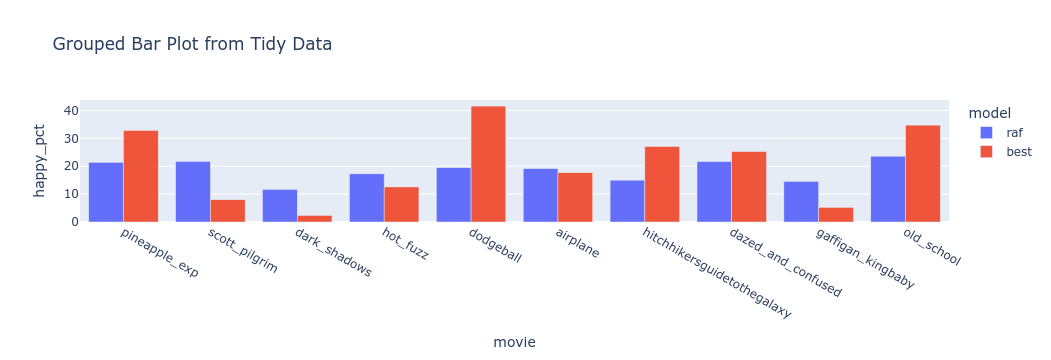

In [27]:
# 2. Create the grouped bar plot using Plotly Express
fig = px.bar(
    coms,
    x="movie",
    y="happy_pct",
    color="model",  # This column defines the groups
    barmode="group",       # Explicitly set the bars to be grouped side-by-side
    title="Grouped Bar Plot from Tidy Data",
    labels={"Category": "Main Category", "Value": "Measured Value", "Sub_Category": "Group"}
)

# 3. Display the figure
fig.show()

In [29]:
best =df[df['model']=='best']

In [30]:
best

,movie,model,angry_pct,fear_pct,happy_pct,sad_pct,surprise_pct,title,category
59,kingsman,best,23.393316,20.308483,24.421594,29.948586,1.928021,Kingsman: The Secret Service,Action
60,hitchhikersguidetothegalaxy,best,13.965517,17.413793,27.068966,35.344828,6.206897,The Hitchhiker's Guide to the Galaxy,Comedy
61,real_steel,best,32.514451,38.583815,10.838150,17.341040,0.722543,Real Steel,Sci-Fi
62,pitch_black,best,8.567208,36.484490,8.124077,44.313146,2.511078,Pitch Black,Sci-Fi
63,lotr_2,best,27.800161,33.037873,5.721193,30.298147,3.142627,The Lord of the Rings: The Two Towers,Fantasy
64,diehard,best,6.885593,44.491525,9.957627,37.711864,0.953390,Die Hard,Action
65,iron_man_3,best,8.950276,53.480663,5.082873,31.491713,0.994475,Iron Man 3,Action
66,scott_pilgrim,best,12.007333,19.340055,7.974335,51.420715,9.257562,Scott Pilgrim vs. the World,Comedy
67,amazing_spider-man_the,best,19.929660,30.246190,14.067995,34.349355,1.406800,The Amazing Spider-Man,Action
68,hp2_chamber_of_secrets,best,15.848407,24.720069,14.987080,40.654608,3.789836,Harry Potter and the Chamber of Secrets,Fantasy


In [31]:
raf =df[df['model']=='raf']

In [32]:
per_cols = [x for x in raf.columns if '_pct' in x]

In [35]:
raf[per_cols].mean()

angry_pct        9.983751
fear_pct         3.132329
happy_pct       18.338153
sad_pct         32.012538
surprise_pct    36.533230
dtype: float64

In [36]:
best[per_cols].mean()

angry_pct       14.867996
fear_pct        35.805871
happy_pct       15.251760
sad_pct         31.119116
surprise_pct     2.955256
dtype: float64

In [37]:
df.columns

Index(['movie', 'model', 'angry_pct', 'fear_pct', 'happy_pct', 'sad_pct',
       'surprise_pct', 'title', 'category'],
      dtype='object')

In [38]:
action = df[df['category']=='Action']

In [39]:
action

,movie,model,angry_pct,fear_pct,happy_pct,sad_pct,surprise_pct,title,category
1,point_break,raf,11.339093,1.511879,24.298056,30.021598,32.829374,Point Break,Action
3,iron_man_3,raf,11.712707,8.618785,16.243094,32.707182,30.718232,Iron Man 3,Action
5,mad_max_fury_road,raf,3.987241,0.159490,15.151515,51.515152,29.186603,Mad Max: Fury Road,Action
7,2_guns,raf,11.556240,5.546995,20.030817,36.055470,26.810478,2 Guns,Action
8,iron_man,raf,8.312020,1.918159,20.204604,30.690537,38.874680,Iron Man,Action
9,avengers_age_of_ultron,raf,8.685446,4.812207,16.431925,27.230047,42.840376,Avengers: Age of Ultron,Action
10,dark_knight,raf,11.428571,3.839286,25.446429,31.339286,27.946429,The Dark Knight,Action
13,iron_man_2,raf,9.500000,3.000000,19.375000,25.375000,42.750000,Iron Man 2,Action
15,kick_ass,raf,7.507508,2.102102,20.120120,27.027027,43.243243,Kick-Ass,Action
18,kingsman,raf,8.097686,0.771208,22.750643,32.519280,35.861183,Kingsman: The Secret Service,Action


In [ ]:
# 2. Create the grouped bar plot using Plotly Express
fig = px.bar(
    coms,
    x="movie",
    y="happy_pct",
    color="model",  # This column defines the groups
    barmode="group",       # Explicitly set the bars to be grouped side-by-side
    title="Grouped Bar Plot from Tidy Data",
    labels={"Category": "Main Category", "Value": "Measured Value", "Sub_Category": "Group"}
)

# 3. Display the figure
fig.show()

In [4]:
genre_map = pd.read_json("movie_list.json")

In [5]:
genre_map.head()

,file_name,title,category
0,2_guns,2 Guns,Action
1,300,300,Action
2,47_ronin,47 Ronin,Action
3,9,9,Animation
4,airplane,Airplane!,Comedy


In [7]:
genre_map[genre_map['category']=='Crime']['file_name']

8              black_mass
9          blackkklansman
10        boondock_saints
18                 domino
45    lucky_number_slevin
54           pulp_fiction
58      seven_psychopaths
Name: file_name, dtype: object